<a href="https://colab.research.google.com/github/azh248/galaxy-mergers-desi/blob/main/zoobot_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import os
import sys

import numpy as np
import pandas as pd

logging.basicConfig(level=logging.INFO)

In [ ]:
import torch
torch.__version__

'2.5.1+cu121'

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Download a pretrained checkpoint from HuggingFace
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning



---



*Retraining will be quite slow unless you use a GPU. Use the top
toolbar: Runtime- > Change Runtime -> GPU*

---

## Install Zoobot

In [ ]:
!pip install zoobot[pytorch-colab] -q



If you will get the error below later:
> AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'requirements'

then restart the runtime and run it again - press the button just above.

In [ ]:
# colab is weird sometimes and erratically needs this hack to make imports work
# no need to do this locally
sys.path.append('/content/galaxy-datasets')
sys.path.append('/content/zoobot')
sys.path.append('/content/zoobot/pytorch')


Now we're set up and can start using Zoobot.

## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [ ]:


# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import gz_desi

data_dir = '/content/gz_desi'

train_catalog, _ = gz_desi(root=data_dir, download=True, train=True)
test_catalog, _ = gz_desi(root=data_dir, download=True, train=False)

100%|██████████| 30797/30797 [00:00<00:00, 1314700.77it/s]


100%|██████████| 10802/10802 [00:00<00:00, 10792489.71it/s]


100%|██████████| 43446358/43446358 [00:02<00:00, 18813483.63it/s]


Extracting /content/demo_rings/demo_rings_images.tar.gz to /content/demo_rings
Using downloaded and verified file: /content/demo_rings/demo_rings_train_catalog.parquet
Using downloaded and verified file: /content/demo_rings/demo_rings_test_catalog.parquet
Using downloaded and verified file: /content/demo_rings/demo_rings_images.tar.gz
Extracting /content/demo_rings/demo_rings_images.tar.gz to /content/demo_rings


In [ ]:
train_catalog.head()

,id_str,ring_fraction,subfolder,filename,ring,file_loc
0,487483_3522,0.714286,487483,487483_3522.jpg,True,/content/demo_rings/images/487483/487483_3522.jpg
1,287521_2026,0.666667,287521,287521_2026.jpg,True,/content/demo_rings/images/287521/287521_2026.jpg
2,519986_112,0.583333,519986,519986_112.jpg,True,/content/demo_rings/images/519986/519986_112.jpg
3,362959_3369,0.800000,362959,362959_3369.jpg,True,/content/demo_rings/images/362959/362959_3369.jpg
4,426137_3385,0.700000,426137,426137_3385.jpg,True,/content/demo_rings/images/426137/426137_3385.jpg


The catalog must have:
- Column(s) with your labels e.g. `ring`.
- `id_str` to identify each row. Can be anything unique.
- `file_loc` column with paths to each image (.jpg, .png and .fits are supported - see the docs)


For multiple classes, use multiple columns with one-hot labels. For example:

In [ ]:
example_multiclass_labels = pd.DataFrame([[0,1,0],[1,0,0],[0, 0,1]], columns=['class_a', 'class_b', 'class_c'])
example_multiclass_labels # just to illustrate. not used here as we're doing binary classification.

,class_a,class_b,class_c
0,0,1,0
1,1,0,0
2,0,0,1


For binary classification, a single column with boolean or integer labels is enough. We'll define `label_cols=["ring"]` below and pass it to our dataloader later.

In [ ]:
label_cols = ['ring']  # will use later
train_catalog['ring']

0       True
1       True
2       True
3       True
4       True
       ...  
795    False
796     True
797    False
798     True
799    False
Name: ring, Length: 800, dtype: bool



Why a list? To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine for classification.

Optional: check `id_str` is unique. No galaxy should appear twice.

In [ ]:
all_id_strs = list(train_catalog['id_str']) + list(test_catalog['id_str'])
assert pd.value_counts(all_id_strs).max() == 1

Optional: check that all images load correctly.

Worth checking once, and especially if you get "InvalidArgumentError" when running the model below.

In [ ]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

In [ ]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

datamodule = GalaxyDataModule(
  label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
  greyscale=False  # Most Zoobot checkpoints expect color images
)

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [ ]:
# just to demonstrate what datamodule returns. you don't need to do this.
datamodule.setup()
for batch in datamodule.train_dataloader():
  images = batch[0]
  labels = batch[1]
  print(images.min(), images.max(), images.shape)
  print(labels)
  break

tensor(0.) tensor(1.) torch.Size([32, 3, 224, 224])
tensor([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.])


## Download Pretrained Model

Download the pretrained model checkpoint from HuggingFace.

Many popular architectures are available. See the collection [here](https://huggingface.co/collections/mwalmsley/zoobot-encoders-65fa14ae92911b173712b874) and the Zoobot [docs](https://zoobot.readthedocs.io/en/latest/data_notes.html). I suggest starting with ConvNeXT-Nano, which is small yet high-performing.



In [ ]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

model = FinetuneableZoobotClassifier(

    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_nano'
    n_blocks=5,  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=1e-5,  # use a low learning rate
    lr_decay=0.5,  # reduce the learning rate from lr to lr^0.5 for each block deeper in the network

    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/62.4M [00:00<?, ?B/s]

# Now the Actual Finetuning

In [ ]:
from zoobot.pytorch.training.finetune import get_trainer

# TODO you can update these paths to suit own data
save_dir = os.path.join('/content/zoobot/results/pytorch/finetune/finetune_binary_classification')

trainer = get_trainer(save_dir, accelerator='auto', devices='auto', max_epochs=30)
trainer.fit(model, datamodule)
# should reach about 85% accuracy, loss of about 0.40

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type           | Params
-----------------------------------------------------
0 | encoder           | ConvNeXt       | 15.0 M
1 | train_loss_metric | MeanMetric     | 0     
2 | val_loss_metric   | MeanMetric     | 0     
3 | test_loss_metric  | MeanMetric     | 0     
4 | head              | LinearHead     | 1.3 K 
5 | train_acc         | BinaryAccuracy | 0     
6 | val_acc           | BinaryAccuracy | 0     
7 | test_acc          | BinaryAccuracy | 0     
-----------------------------------------------------
15.0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 17: 'finetuning/val_loss' reached 0.55552 (best 0.55552), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 34: 'finetuning/val_loss' reached 0.52720 (best 0.52720), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 51: 'finetuning/val_loss' reached 0.48349 (best 0.48349), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 68: 'finetuning/val_loss' reached 0.45551 (best 0.45551), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 85: 'finetuning/val_loss' reached 0.42005 (best 0.42005), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 102: 'finetuning/val_loss' reached 0.39247 (best 0.39247), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 119: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 136: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 153: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 170: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 187: 'finetuning/val_loss' reached 0.36170 (best 0.36170), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 204: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 221: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 238: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 255: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 272: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 289: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 306: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 323: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 340: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 357: 'finetuning/val_loss' was not in top 1


In [ ]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

In [ ]:
from zoobot.pytorch.predictions import predict_on_catalog

_ = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_ring', 'ring'],  # name the output columns
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Let's quickly check if they're any good:

In [ ]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
predictions.head()

,id_str,not_ring_pred,ring_pred
0,453526_3245,0.289047,0.710953
1,127202_5277,0.075943,0.924057
2,469597_327,0.855560,0.144440
3,433105_1762,0.930863,0.069137
4,52497_3109,0.150954,0.849046


In [ ]:

predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'ring']])
predictions.head()

,id_str,not_ring_pred,ring_pred,file_loc,ring
0,453526_3245,0.289047,0.710953,/content/demo_rings/images/453526/453526_3245.jpg,True
1,127202_5277,0.075943,0.924057,/content/demo_rings/images/127202/127202_5277.jpg,True
2,469597_327,0.855560,0.144440,/content/demo_rings/images/469597/469597_327.jpg,False
3,433105_1762,0.930863,0.069137,/content/demo_rings/images/433105/433105_1762.jpg,False
4,52497_3109,0.150954,0.849046,/content/demo_rings/images/52497/52497_3109.jpg,True


In [ ]:
print('Accuracy:', np.mean(np.around(predictions['ring_pred']) == predictions['ring']))

Accuracy: 0.79


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['ring_pred']) == galaxy['ring']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['ring_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['ring']), color=color)

    axes[n].axis('off')

187    431201_4792
50     496393_4172
45     228384_1060
153    336726_4206
86      498880_985
          ...     
118    341124_2594
142    327030_1714
127    507378_1088
57     348565_3693
29     321138_1803
Name: id_str, Length: 200, dtype: object


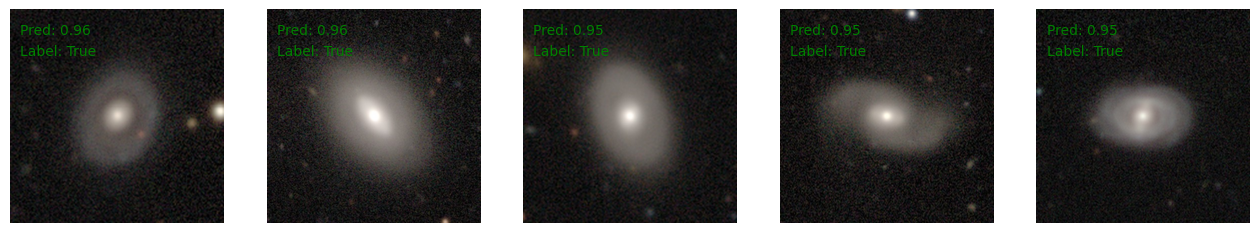

In [ ]:
top_5_predictions = predictions.sort_values('ring_pred', ascending=False)
show_rings(top_5_predictions)
print(top_5_predictions['id_str'])

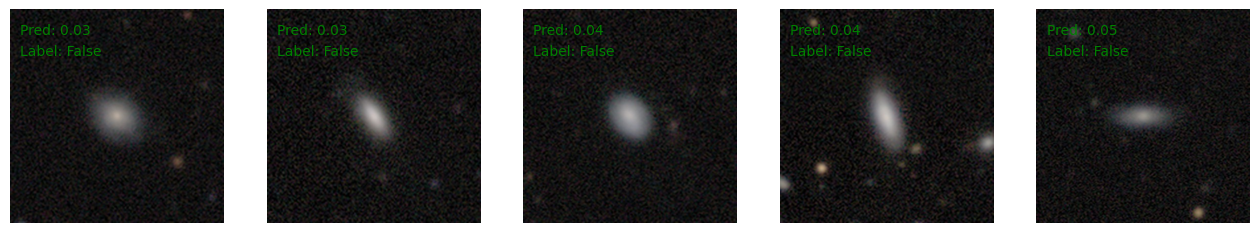

In [ ]:
bottom_5_predictions = predictions.sort_values('ring_pred', ascending=True)
show_rings(bottom_5_predictions)

74      441403_526
160     444258_706
183    354313_2098
168     130661_693
10      352837_131
Name: id_str, dtype: object


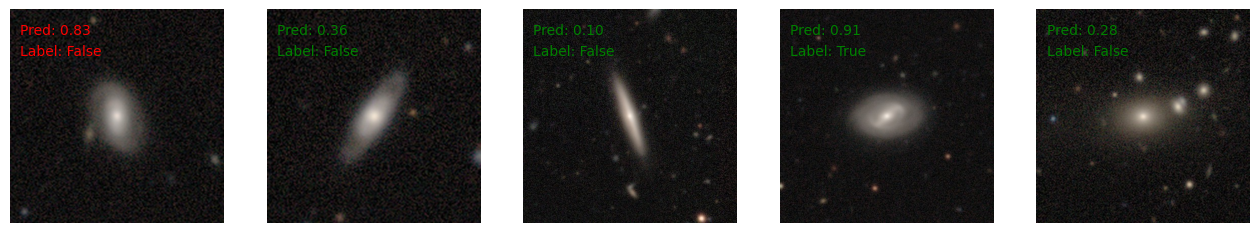

In [ ]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

Pretty good given only a couple of hundred examples for each class.


## Saving predictions to HDF5

By the way - you can also save predictions to hdf5. This is useful for saving higher-dimensional outputs (e.g. representations or multiple forward passes).

In [ ]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=5,  # 5 forward passes with MC Dropout and different random augs
  label_cols=['not_ring', 'ring'],
  save_loc=os.path.join(save_dir, 'finetuned_predictions.hdf5'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

import h5py

with h5py.File(os.path.join(save_dir, 'finetuned_predictions.hdf5')) as f:
  print(f.keys())
  print(f['predictions'].shape)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<KeysViewHDF5 ['id_str', 'label_cols', 'predictions']>
(200, 2, 5)
